In [48]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd

#from Model_xx import Model
from Model_xx import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Parameters and Initialization

In [70]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100
steps = 100

In [71]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
model = Model(N_inp, N_bar, num_states, steps=steps)

In [72]:
cache_states = [0, 10, 20, 30, 40, 50, 60, 70, 80]

# Run Task (with learning)

In [73]:
model.reset()
cache_acts = []
cache_acts_over_time = []

for cache_state in cache_states:
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])
    cache_acts.append(acts.copy())
    cache_acts_over_time.append(acts_over_time.copy())

Now I just cached at location: 0
Now I just cached at location: 10
Now I just cached at location: 20
Now I just cached at location: 30
Now I just cached at location: 40
Now I just cached at location: 50
Now I just cached at location: 60
Now I just cached at location: 70
Now I just cached at location: 80


In [74]:
_, _, output, retrieval_acts_over_time = model.run_recall(0., place_inputs)

In [75]:
_, place_acts, _, _ = model.run_nonrecurrent(place_inputs)
place_mean = np.mean(place_acts, axis=0).flatten()
place_std = np.std(place_acts, axis=0).flatten()

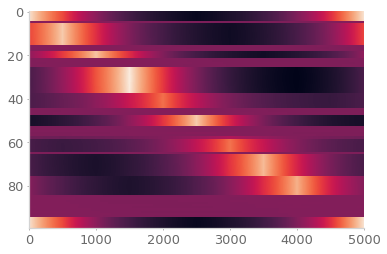

In [76]:
plt.figure()
plt.imshow(output, aspect='auto')
plt.show()

# Define cache activity as a mean over some time window

In [77]:
avg_cache_acts = []
for i in range(len(cache_states)):
    location = cache_states[i]
    vec = cache_acts_over_time[i][steps+model.seed_steps-1, location, :]#.mean(axis=0)
    avg_cache_acts.append(vec)
avg_cache_acts = np.array(avg_cache_acts)

In [78]:
cache_mean = avg_cache_acts.mean(axis=0)

In [79]:
avg_retrieval_acts = []
for i in range(len(cache_states)):
    location = cache_states[i]
    vec = retrieval_acts_over_time[steps-1, location, :]#.mean(axis=0)
    avg_retrieval_acts.append(vec)
avg_retrieval_acts = np.array(avg_retrieval_acts)

In [80]:
def nb(mu, std_scaling=1.0, mu_scaling=0.75, shift=0.0):
    """ mu is a vector of firing rates. std_scaling is a scalar. """


    mu = mu*mu_scaling + 1E-8 + shift
    std = std_scaling * np.sqrt(mu)
    std += 1E-8
    n = (mu**2)/(std**2 - mu)
    p = mu/(std**2)
    nb_mu = nbinom.rvs(n, p)
    return nb_mu.astype(float)


def nb_corr(a, b):
    nb_a = nb(a)
    nb_b = nb(b)
    return np.corrcoef(nb_a, nb_b)[0, 1]

# Fig 3ab, Fig 4: cache v. visit correlation

In [92]:
cache_cache_corr = {'Distance': [], 'Correlation': []}
cache_visit_corr = {'Distance': [], 'Correlation': []}
visit_visit_corr = {'Distance': [], 'Correlation': []}
cache_retrieval_corr = {'Distance': [], 'Correlation': []}
std_scaling = 1

for i in range(len(cache_states)):
    for j in range(i, len(cache_states)):
        _distance = distance(cache_states[i], cache_states[j], num_states)
        
        cache_act_i = avg_cache_acts[i].copy()
        cache_act_j = avg_cache_acts[j].copy()
        retrieval_act_j = avg_retrieval_acts[j].copy()
        place_act_i = place_acts[cache_states[i]].copy()
        place_act_j = place_acts[cache_states[j]].copy()
        
        for _ in range(3): # More samples
            c_c_corr = nb_corr(cache_act_i, cache_act_j)
            c_v_corr = nb_corr(cache_act_i, place_act_j)
            v_v_corr = nb_corr(place_act_i, place_act_j)
            c_r_corr = nb_corr(cache_act_i, retrieval_act_j)

            cache_cache_corr['Distance'].append(_distance)
            cache_cache_corr['Correlation'].append(c_c_corr)

            cache_visit_corr['Distance'].append(_distance)
            cache_visit_corr['Correlation'].append(c_v_corr)

            visit_visit_corr['Distance'].append(_distance)
            visit_visit_corr['Correlation'].append(v_v_corr)
            
            cache_retrieval_corr['Distance'].append(_distance)
            cache_retrieval_corr['Correlation'].append(c_r_corr)


In [93]:
# cc

In [98]:
ccc = pd.DataFrame(cache_cache_corr)
ccc = ccc[ccc['Distance']==0]
print(ccc)

     Distance  Correlation
0           0     0.503134
1           0     0.495562
2           0     0.589347
27          0     0.538947
28          0     0.507756
29          0     0.515818
51          0     0.447043
52          0     0.469956
53          0     0.549596
72          0     0.535892
73          0     0.522427
74          0     0.468472
90          0     0.497693
91          0     0.544365
92          0     0.492382
105         0     0.569329
106         0     0.537968
107         0     0.491392
117         0     0.509128
118         0     0.523526
119         0     0.421440
126         0     0.559290
127         0     0.491790
128         0     0.585579
132         0     0.528928
133         0     0.541885
134         0     0.529905


In [99]:
np.mean(ccc)

Distance       0.000000
Correlation    0.517354
dtype: float64

In [96]:
# cr

In [100]:
crc = pd.DataFrame(cache_retrieval_corr)
crc = crc[crc['Distance']==0]
print(crc)

     Distance  Correlation
0           0     0.599238
1           0     0.499622
2           0     0.547805
27          0     0.514866
28          0     0.581644
29          0     0.584970
51          0     0.596257
52          0     0.594356
53          0     0.530720
72          0     0.575018
73          0     0.588031
74          0     0.596240
90          0     0.549932
91          0     0.490440
92          0     0.560763
105         0     0.601688
106         0     0.602733
107         0     0.598317
117         0     0.483322
118         0     0.566747
119         0     0.572806
126         0     0.626368
127         0     0.588379
128         0     0.535053
132         0     0.619809
133         0     0.628610
134         0     0.567731


In [102]:
np.mean(crc)

Distance       0.000000
Correlation    0.570424
dtype: float64

In [103]:
# vv

In [104]:
vvc = pd.DataFrame(visit_visit_corr)
vvc = vvc[vvc['Distance']==0]

In [105]:
np.mean(vvc)

Distance       0.000000
Correlation    0.220102
dtype: float64

# Plot

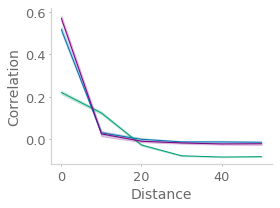

In [114]:
plt.figure(figsize=(4,3))
sns.lineplot(x='Distance', y='Correlation', data=pd.DataFrame(cache_cache_corr), color='C0')
sns.lineplot(x='Distance', y='Correlation', data=pd.DataFrame(visit_visit_corr), color='C2')
sns.lineplot(x='Distance', y='Correlation', data=pd.DataFrame(cache_retrieval_corr), color='purple')
plt.tight_layout()
plt.savefig('c_r_corr.png')
plt.show()